# Fair Housing Group: Week 7 Assignment

**Members: Chase Engelhardt, Christine Bustillos, Victor Tran, Shweta Sundar**

In this assignment we will be pooling our collective cleaned-up work with detailed markdown cells below outputs explaining their significance. Additionally we have created a function that allows us to dissolve census data into neighborhood shapes

# Import Libraries

In [2]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# Census Tract To Neighborhood Function
It takes census tract level geospatial data and dissolves it into neighborhood shapes. 
The arguments you need are your data frame (i.e. 'df= your data frame', your geometry column, usually named 'geometry' (i.e. "geometry='geometry'", and lastly how you want the variables to be summarized (i.e. 'sum' to add or 'mean' for an average)

In [3]:
def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.head()
    return nhdata
    

## Here's an example input:

**test=nhdissolve(df=racedf,geometry='geometry, math='sum')**

## Once you've run the function with your dataframe:
You can call for your new variable in a map 

In the example above this would be 'test'

I'll run an example below:

In [4]:
# step 1- import your data (needs to have a geometry column) 
testdf=pd.read_csv('data/racetracts.csv')

In [5]:
# Step 2- plug it into the function 
example= nhdissolve(df=testdf,geometry='geometry',math='sum')

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [6]:
# Don't worry about the warning^^ it's just talking about one of the functions that's due for a change
# Step 3- plot or work with your newly adjusted geodataframe 
example.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 114 entries, Adams-Normandie to Woodland Hills
Data columns (total 14 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   geometry                                                 114 non-null    geometry
 1   Unnamed: 0                                               114 non-null    int64   
 2   CT20                                                     114 non-null    int64   
 3   FIPS                                                     114 non-null    int64   
 4   TotalPop                                                 114 non-null    int64   
 5   Non Hispanic                                             114 non-null    int64   
 6   Non Hispanic White Alone                                 114 non-null    int64   
 7   Non Hispanic Black Alone                                 114 non-null    int64 

In [7]:
example['BIPOC']= example['TotalPop']-example['Non Hispanic White Alone']
example.info()



<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 114 entries, Adams-Normandie to Woodland Hills
Data columns (total 15 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   geometry                                                 114 non-null    geometry
 1   Unnamed: 0                                               114 non-null    int64   
 2   CT20                                                     114 non-null    int64   
 3   FIPS                                                     114 non-null    int64   
 4   TotalPop                                                 114 non-null    int64   
 5   Non Hispanic                                             114 non-null    int64   
 6   Non Hispanic White Alone                                 114 non-null    int64   
 7   Non Hispanic Black Alone                                 114 non-null    int64 

In [14]:
racelist=['Non Hispanic White Alone','Non Hispanic Black Alone', 'Non Hispanic American Indian and Alaska Native Alone', 'Non Hispanic Asian Alone', 'Non Hispanic Native Hawaiian and Pacific Islander Alone', 'Non Hispanic Other Alone', 'Non Hispanic Multi Race', 'Hispanic','BIPOC']

for r in racelist:
        example['Percent'+' '+r]= (example[r]/example['TotalPop'])*100
        
example.head()

,geometry,Unnamed: 0,CT20,FIPS,TotalPop,Non Hispanic,Non Hispanic White Alone,Non Hispanic Black Alone,Non Hispanic American Indian and Alaska Native Alone,Non Hispanic Asian Alone,...,BIPOC,Percent Non Hispanic White Alone,Percent Non Hispanic Black Alone,Percent Non Hispanic American Indian and Alaska Native Alone,Percent Non Hispanic Asian Alone,Percent Non Hispanic Native Hawaiian and Pacific Islander Alone,Percent Non Hispanic Other Alone,Percent Non Hispanic Multi Race,Percent Hispanic,Percent BIPOC
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Adams-Normandie,"POLYGON ((-118.30541 34.02571, -118.30890 34.0...",8267,2439227,66409439227,36861,15352,3804,5859,60,4337,...,33057,10.319850,15.894848,0.162774,11.765823,0.092238,0.664659,2.748162,58.351645,89.680150
Arleta,"POLYGON ((-118.43579 34.22987, -118.43582 34.2...",2064,1667245,84519667245,56835,17156,8872,757,91,6513,...,47963,15.610099,1.331926,0.160113,11.459488,0.077417,0.355415,1.191167,69.814375,84.389901
Arlington Heights,"POLYGON ((-118.33381 34.03501, -118.33271 34.0...",9227,2820162,78483820162,43166,21826,4339,5989,69,9858,...,38827,10.051893,13.874346,0.159848,22.837418,0.048649,0.694991,2.895798,49.437057,89.948107
Atwater Village,"POLYGON ((-118.27051 34.12151, -118.27331 34.1...",11440,3729825,72447729825,48540,32363,22006,1051,92,7536,...,26534,45.335806,2.165225,0.189534,15.525340,0.088587,0.379069,2.989287,33.327153,54.664194
Baldwin Hills/Crenshaw,"POLYGON ((-118.36504 34.00556, -118.36623 34.0...",24408,7467665,126784467665,73917,51807,9726,33070,117,4061,...,64191,13.158002,44.739370,0.158286,5.494000,0.127170,0.993006,5.418239,29.911928,86.841998


In [13]:
percentlist=['Percent'+' '+r  for r in racelist] 


['Percent Non Hispanic White Alone',
 'Percent Non Hispanic Black Alone',
 'Percent Non Hispanic American Indian and Alaska Native Alone',
 'Percent Non Hispanic Asian Alone',
 'Percent Non Hispanic Native Hawaiian and Pacific Islander Alone',
 'Percent Non Hispanic Other Alone',
 'Percent Non Hispanic Multi Race',
 'Percent Hispanic',
 'Percent BIPOC']

In [9]:
df2=example['Non Hispanic White Alone'].sum()/example['TotalPop'].sum()


df2

0.31435751386457966

# Mapping Race in Los Angeles By Neighborhood

As we consider gentrification and segregation, understanding demographics by neighborhood is crucial. Here are some maps of demographics by race in City of LA Neighborhoods.

In [18]:
# create a list of relevant columns 
# write a loop to plot static maps per column
for r in percentlist:
    fig, ax = plt.subplots(figsize=(20, 15))
    example.plot(
                 column=r,
                 legend=True, 
                 cmap='RdPu',
                 scheme='User_Defined',
                 classification_kwds=dict(bins=[20,40,60,80,100]),
                 ax=ax)
    ax.axis('off')

    ax.set_title(r+' '+'Population in Los Angeles',fontsize = 25)

    ctx.add_basemap(ax,
               crs=4326,
               source=ctx.providers.CartoDB.Positron
              )
    plt.savefig(f'./racemap:+{r}.png')    
    plt.close()

### Results
You can tell how patterns of segregation reinforced by redlining and other racist planning practices have maintained a lot of majority white neighborhoods along the coast and in the Western portions of the Valley. Visualizing patterns like this will help in contextualizing where resources like parks, job access and healthcare facilitites are concentrated. 

# Examining Rent/Severe Rent Burden

Now, I will load the data I download from Social Explorer, with data in census tracts in LA County (FIPS code: 06037) on "Residents Paying More Than 30% or at least 50% of Income on Rents". Data Source: Social Explorer Tables: ACS 2021 (5-Year Estimates)(SE), ACS 2021 (5-Year Estimates), Social Explorer; U.S. Census Bureau

In [7]:
LACounty = pd.read_csv('data/LA_County_Rent_Burden.csv')

Assigning data types on import - Upon importing the data, I am looking closer at the FIPS code column that will be the unique identifier

In [8]:
LACounty = pd.read_csv(
    'data/LA_County_Rent_Burden.csv',
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
)

Drop/Delete the Null Columns - It is evident that many of the columns in the social explorer dataset I downloaded have null values (i.e. have no entries/data in them). To find out what the null columns are in the data, I will use the isna() and .all() commands, to find the columns that have all empty values

In [9]:
LACounty.columns[LACounty.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_STATECE',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_BLKGRP',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITSCE',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_UACP',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_VTD',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_TAZ',
 'Geo_UGA',
 'Geo_PUMA5',
 'Geo_PUMA1',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PLACESE']

Now that I have a list of columns that do not have data in them, I will proceed to eliminate them from the data to simplify it. I will use the .dropna() command with the additional arguments of axis=1 and how="all"

In [10]:
LACounty = LACounty.dropna(axis=1,how="all")

Defining Columns to Keep - With the data I downloaded from social explorer, I also looked at the data dictionary to understand which columns would be useful for my particular research inquiry. I will only keep the four columns listed below:
- GeoFIPS: Geographic identifier
- SE_B18002_001: Renter-Occupied Housing Units
- SE_B18002_002: Renter-Occupied Housing Units: 30 to 49 Percent
- SE_B18002_003: Renter-Occupied Housing Units: 50 percent or More

I will define the columns I want to keep by creating a subset of the dataframe and creating a new dataframe, now called Rent Burden

In [11]:
columns_to_keep = ['Geo_FIPS',
                   'SE_B18002_001',
                   'SE_B18002_002',
                   'SE_B18002_003']
RentBurden = LACounty[columns_to_keep]

Renaming Columns - The automatic column names from social explorer/the census data are not very useful or memorable; I will create a list of column names and replaced the values with my new desired column names = 'FIPS', 'Renter-Occupied Housing Units', 'Residents Paying 30% to 49% of Income on Rent', and 'Residents Paying 50% or more of Income on Rent'

In [12]:
columns = list(RentBurden)
columns

['Geo_FIPS', 'SE_B18002_001', 'SE_B18002_002', 'SE_B18002_003']

In [13]:
RentBurden.columns = ['FIPS',
'Renter-Occupied Housing Units',
'Residents Paying 30% to 49% of Income on Rent',
'Residents Paying 50% or more of Income on Rent']

<AxesSubplot: ylabel='Frequency'>

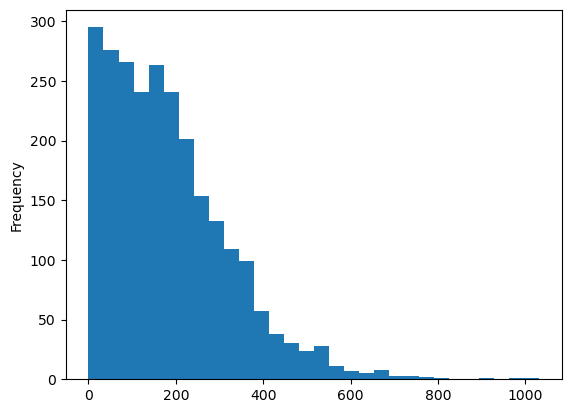

In [14]:
# I will now plot the 'Residents Paying 30% to 49% of Income on Rent' variable
# as a histogram with 30 bins
RentBurden['Residents Paying 30% to 49% of Income on Rent'].plot.hist(bins=30)

<AxesSubplot: >

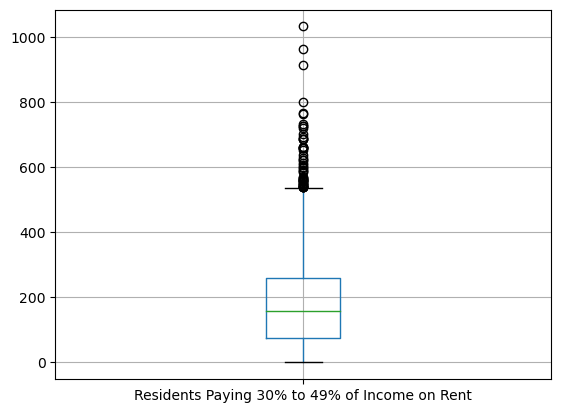

In [15]:
# I can generate a box plot for the same varible
RentBurden.boxplot(column=['Residents Paying 30% to 49% of Income on Rent'])

<AxesSubplot: xlabel='Residents Paying 30% to 49% of Income on Rent', ylabel='Renter-Occupied Housing Units'>

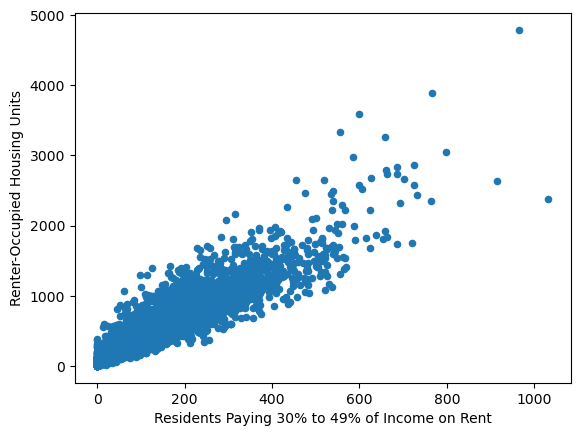

In [16]:
# For a scatterplot, I have made the x-axis 'Residents Paying 30% to 49% of Income on Rent',
# and the y-axis Renter-Occupied Housing Units'
RentBurden.plot.scatter(x='Residents Paying 30% to 49% of Income on Rent',y='Renter-Occupied Housing Units')

Sorting the Data (Top-Down) - What are the top 10 census tracts with the most number of residents experiencing rent burden (spending 30%-49% of their incomes on rent)? We can sort the data by this column.

In [17]:
RentBurdenSorted = RentBurden.sort_values(by='Residents Paying 30% to 49% of Income on Rent',ascending = False)

In [18]:
# I have sorted the data and will display the top 10 census tracts
RentBurdenSorted[['FIPS','Residents Paying 30% to 49% of Income on Rent']].head(10)

,FIPS,Residents Paying 30% to 49% of Income on Rent
602,06037207502,1032
2278,06037702900,964
2249,06037700902,914
2264,06037701902,799
2239,06037700200,766
2036,06037576602,764
604,06037207712,732
1028,06037275604,725
2026,06037576200,725
92,06037111402,721


<AxesSubplot: xlabel='FIPS'>

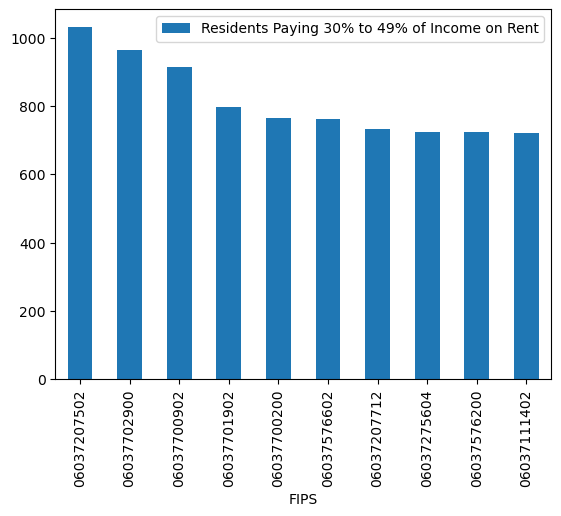

In [19]:
# I can plot these results
RentBurdenSorted.head(10).plot.bar(x='FIPS',
                            y='Residents Paying 30% to 49% of Income on Rent')

What are the top 10 census tracts with the most number of residents experiencing severe rent burden (spending 50% or more of their incomes on rent)? Again, we can sort the data by this column and plot it

In [20]:
SevereRentBurdenSorted = RentBurden.sort_values(by='Residents Paying 50% or more of Income on Rent',ascending = False)

In [21]:
SevereRentBurdenSorted[['FIPS','Residents Paying 50% or more of Income on Rent']].head(10)

,FIPS,Residents Paying 50% or more of Income on Rent
2278,06037702900,1324
2239,06037700200,1066
1124,06037301601,1065
1123,06037301502,946
319,06037134905,896
606,06037207902,858
939,06037265303,855
1142,06037302401,852
2026,06037576200,849
472,06037191000,843


<AxesSubplot: xlabel='FIPS'>

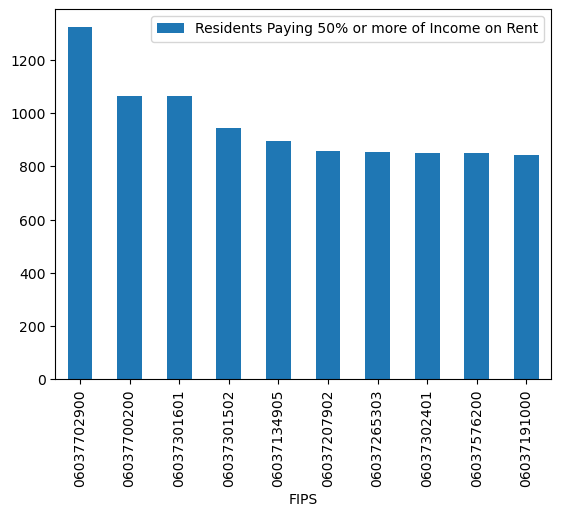

In [22]:
SevereRentBurdenSorted.head(10).plot.bar(x='FIPS',
                            y='Residents Paying 50% or more of Income on Rent')

Mapping with Geopandas - With using Geopandas, I have found a geojson file from the Los Angeles GeoHub that shows all the census tracts in the city of Los Angeles based on the 2010 population

In [23]:
LACountyTracts=gpd.read_file('data/Census_Tracts_2020.geojson')

In [24]:
LACountyTracts = LACountyTracts[['CT20','geometry']]

Since the 'TRACTCE10' FIPS code column currently is missing the state and county code, I need to add them and create a new FIPS column

In [25]:
LACountyTracts['FIPS'] ='06' + '037' + LACountyTracts['CT20']

Merging and Joining the Data - After cleaning up my data, I have the census data from social explorer and the geo data from the Los Angeles GeoHub - with both having the correct FIPS code. I will create a new dataframe based on this join

In [26]:
RentBurdenTracts=LACountyTracts.merge(RentBurden,on="FIPS")

Creating Choropleth Maps in Geopandas - Since I have three variables of interest:

- 'Renter-Occupied Housing Units'
- 'Residents Paying 30% to 49% of Income on Rent'
- 'Residents Paying 50% or more of Income on Rent'

I can create choropleth maps for each of them in geopandas, using the quantiles color scheme

Choropleth Map for 'Residents Paying 30% to 49% of Income on Rent' using the Quantiles and Natural Breaks schemes

<AxesSubplot: >

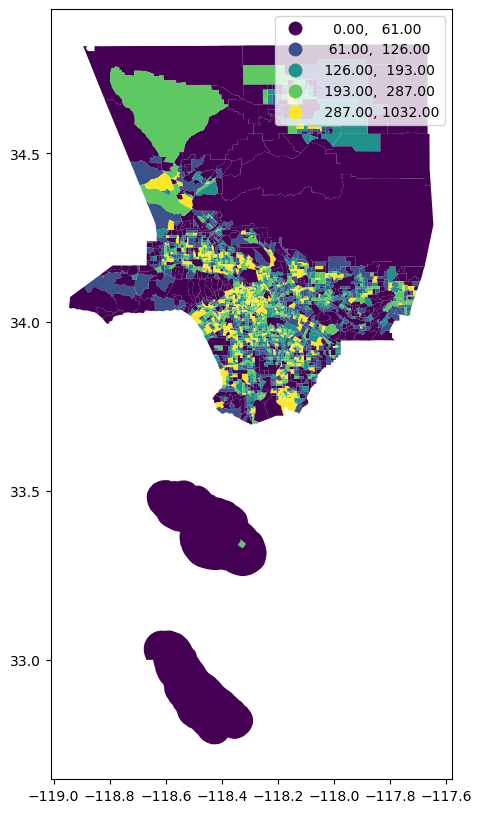

In [27]:
RentBurdenTracts.plot(figsize=(12,10),
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='quantiles')

<AxesSubplot: >

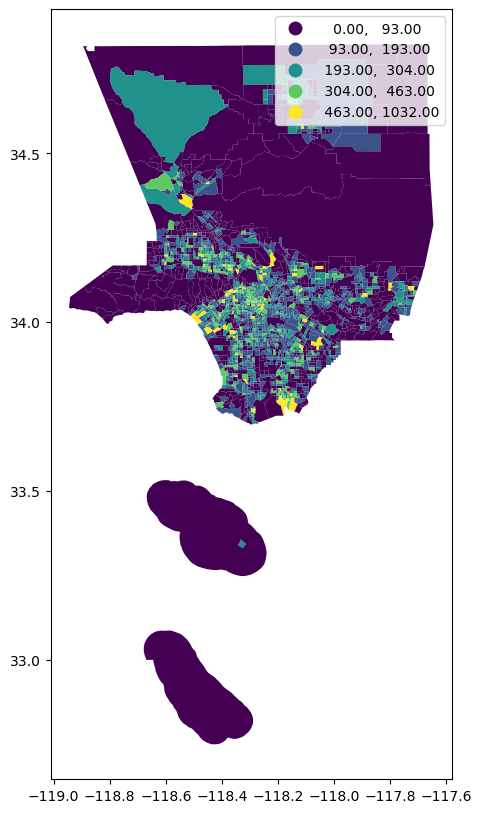

In [28]:
# Choropleth Map for 'Residents Paying 30% to 49% of Income on Rent' using the
# Natural Breaks scheme
RentBurdenTracts.plot(figsize=(12,10),
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='NaturalBreaks')

<AxesSubplot: >

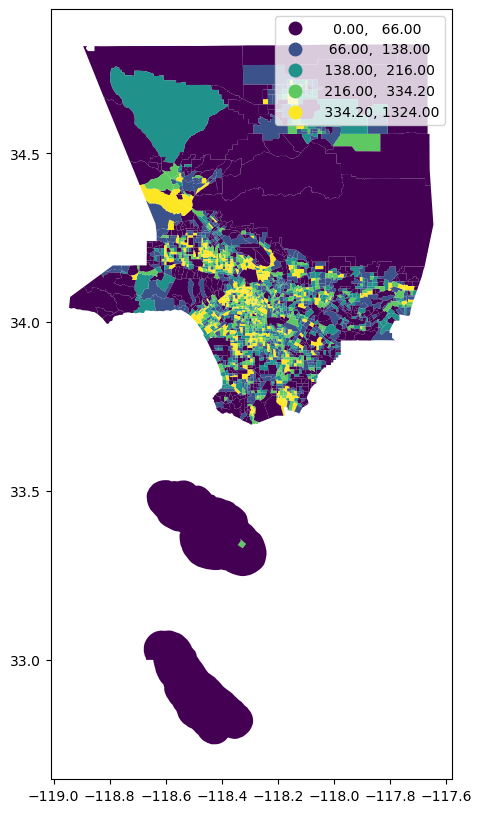

In [29]:
# Choropleth Map for 'Residents Paying 50% or more of Income on Rent' using the
# quantiles scheme
RentBurdenTracts.plot(figsize=(12,10),
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='quantiles')

<AxesSubplot: >

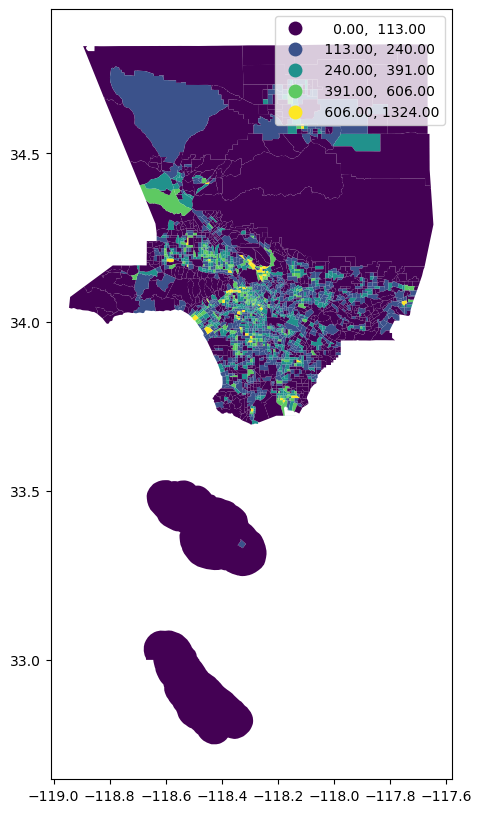

In [30]:
# Choropleth Map for 'Residents Paying 50% or more of Income on Rent' using the
# Natural Breaks scheme
RentBurdenTracts.plot(figsize=(12,10),
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='NaturalBreaks')

<AxesSubplot: >

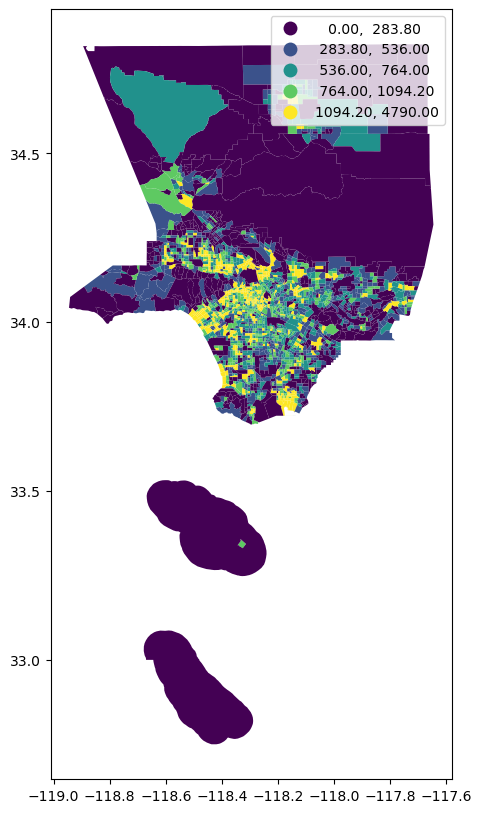

In [31]:
# Choropleth Map for 'Renter-Occupied Housing Units' using the
# quantiles scheme
RentBurdenTracts.plot(figsize=(12,10),
                 column='Renter-Occupied Housing Units',
                 legend=True, 
                 scheme='quantiles')

<AxesSubplot: >

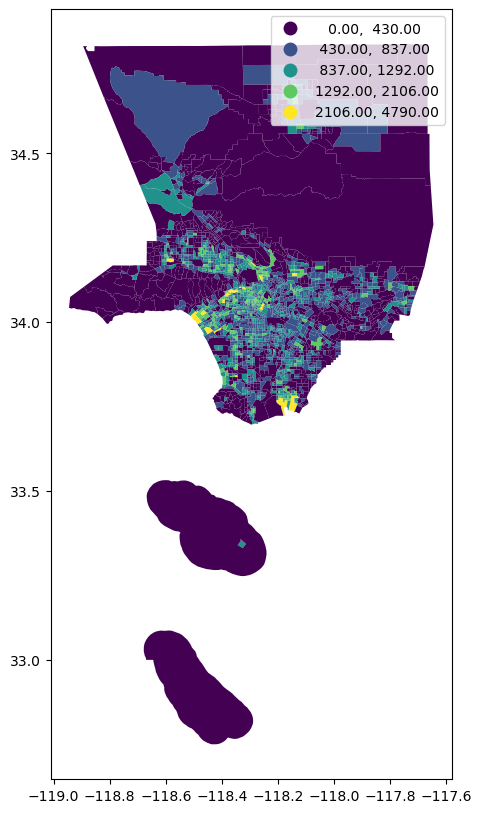

In [32]:
# Choropleth Map for 'Renter-Occupied Housing Units' using the
# Natural Breaks scheme
RentBurdenTracts.plot(figsize=(12,10),
                 column='Renter-Occupied Housing Units',
                 legend=True, 
                 scheme='NaturalBreaks')

Since the maps are all focusing on LA County as a whole, I will assign additional arguments to zoom the map into LA City and restrict the plot by the coordinates that represent LA City

In [33]:
import matplotlib.pyplot as plt

(-118.7, -118.12)

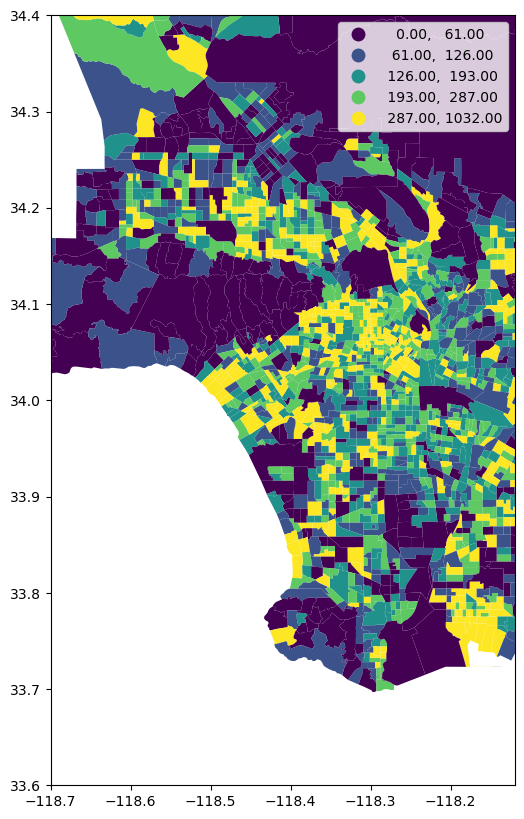

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenTracts.plot(
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.set_ylim(33.6, 34.4)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

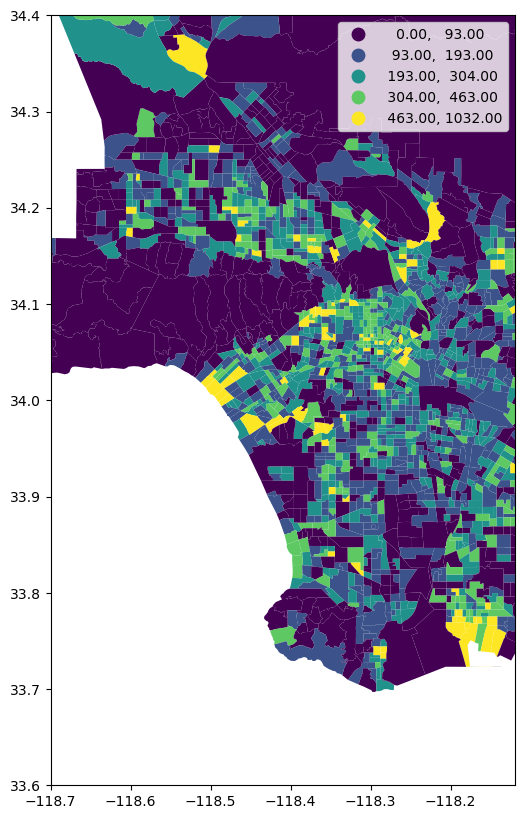

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenTracts.plot(
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='NaturalBreaks',
                 ax=ax)

ax.set_ylim(33.6, 34.4)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

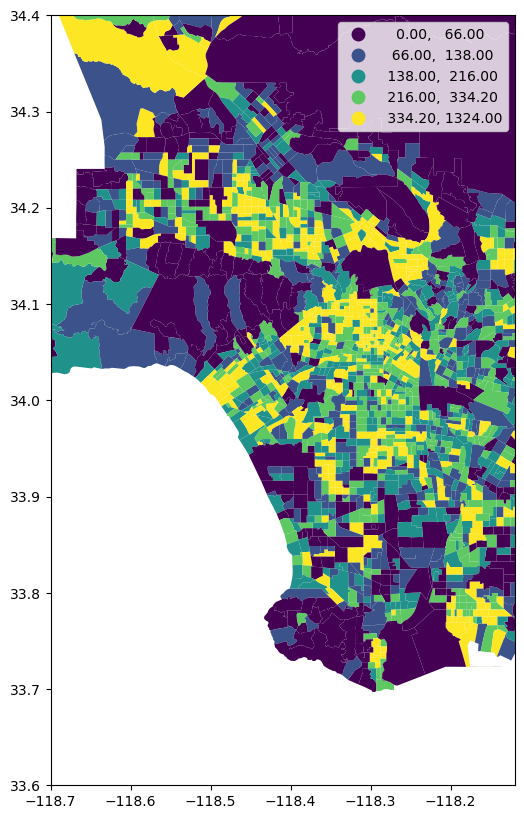

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenTracts.plot(
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.set_ylim(33.6, 34.4)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

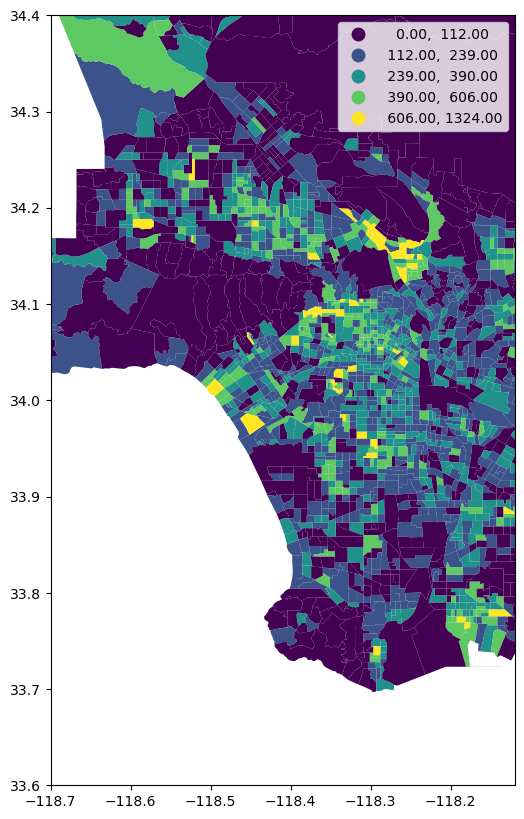

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenTracts.plot(
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='NaturalBreaks',
                 ax=ax)

ax.set_ylim(33.6, 34.4)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

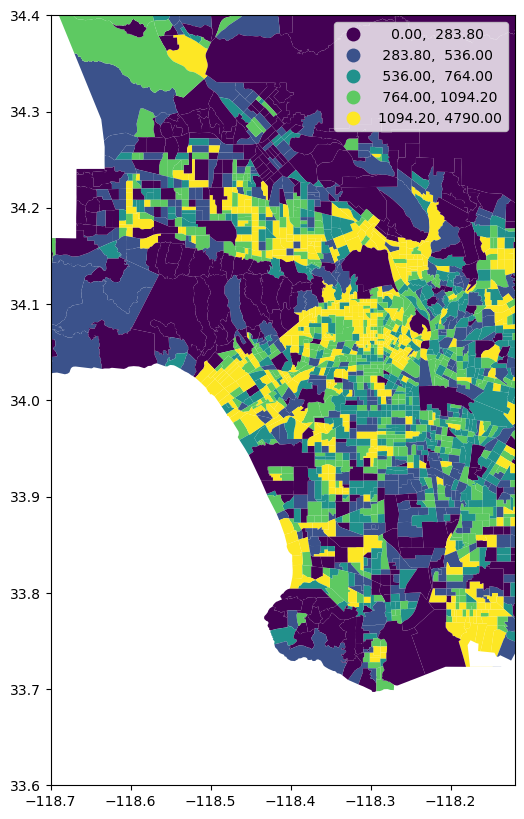

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenTracts.plot(
                 column='Renter-Occupied Housing Units',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.set_ylim(33.6, 34.4)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

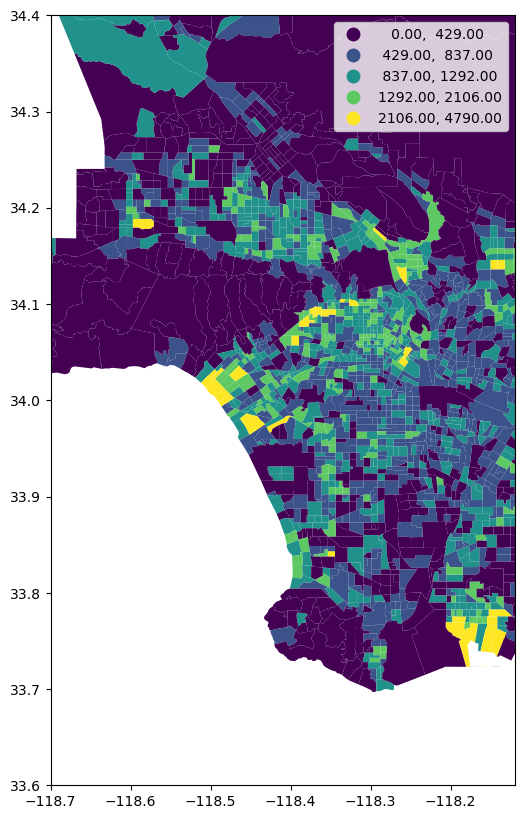

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenTracts.plot(
                 column='Renter-Occupied Housing Units',
                 legend=True, 
                 scheme='NaturalBreaks',
                 ax=ax)

ax.set_ylim(33.6, 34.4)
ax.set_xlim(-118.7,-118.12)

I will try to use the overlay function to see if I can only get the city of Los Angeles to show up on the map - I followed this [tutorial](https://geopandas.org/en/stable/docs/user_guide/set_operations.html)

In [40]:
#Importing a LA boundary map
LACityOutline = gpd.read_file('data/City_Boundary.geojson')

In [41]:
RentBurdenLACity = RentBurdenTracts.overlay(LACityOutline, how ='intersection')

(-118.7, -118.12)

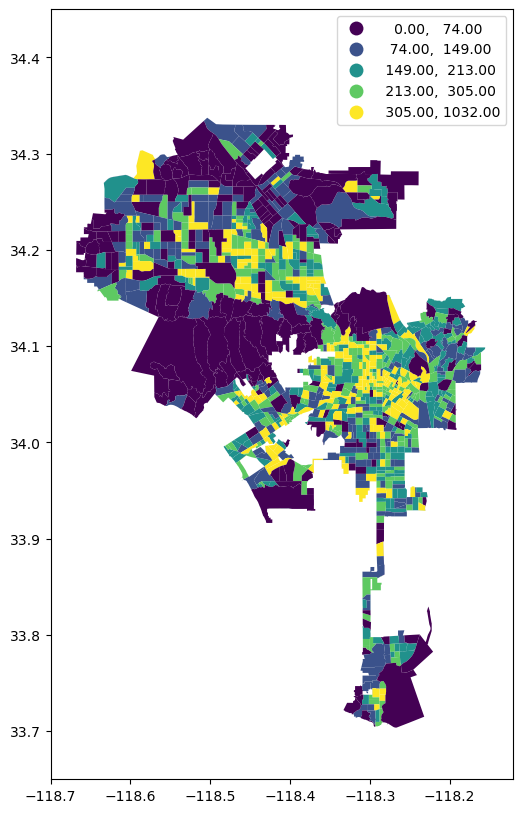

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenLACity.plot(
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.set_ylim(33.65, 34.45)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

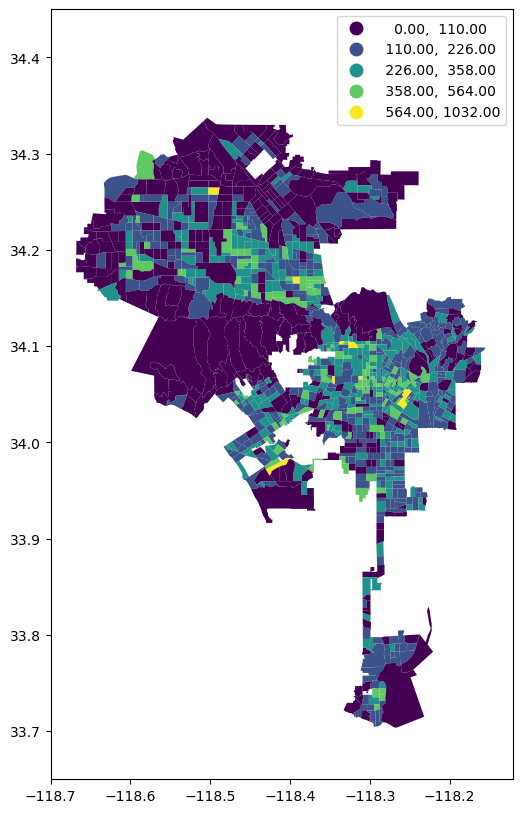

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenLACity.plot(
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='NaturalBreaks',
                 ax=ax)

ax.set_ylim(33.65, 34.45)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

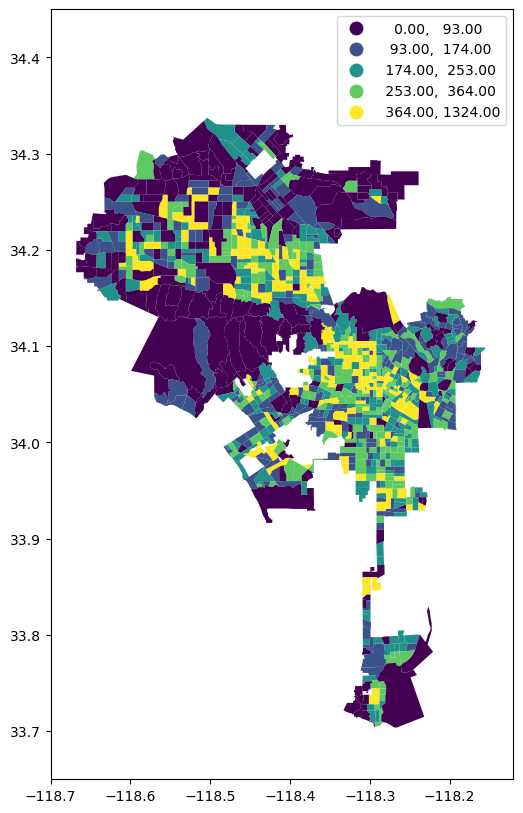

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenLACity.plot(
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.set_ylim(33.65, 34.45)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

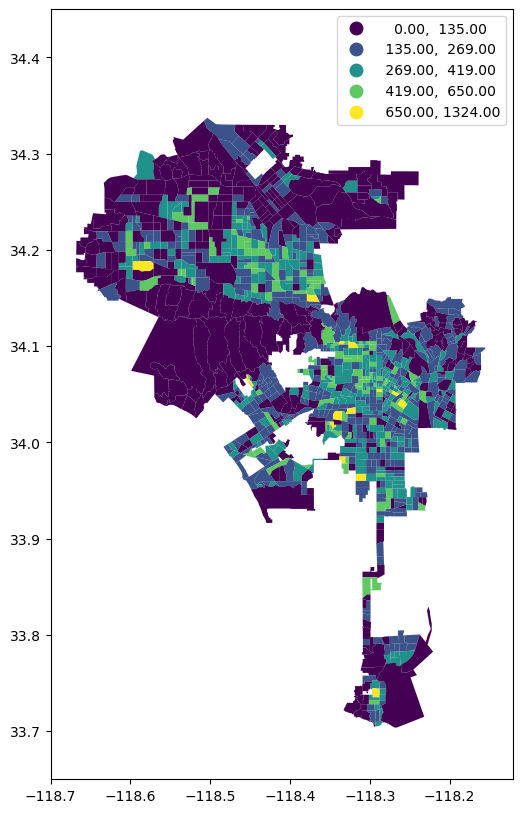

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenLACity.plot(
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='NaturalBreaks',
                 ax=ax)

ax.set_ylim(33.65, 34.45)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

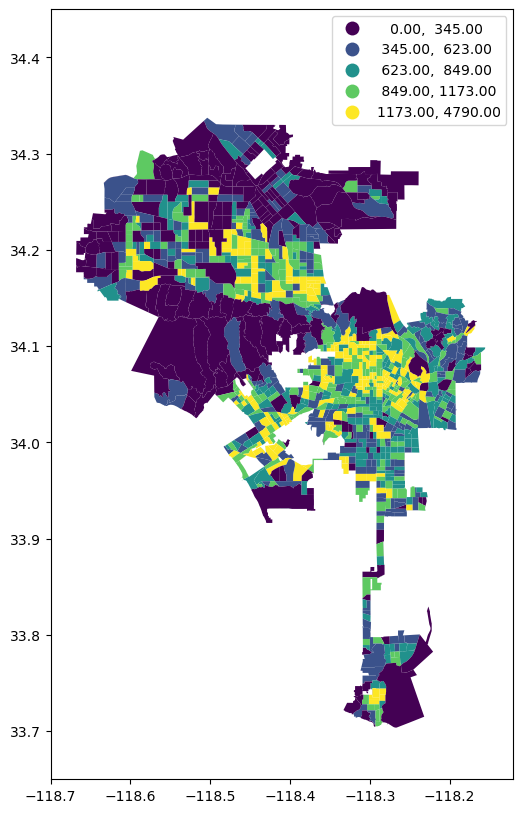

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenLACity.plot(
                 column='Renter-Occupied Housing Units',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.set_ylim(33.65, 34.45)
ax.set_xlim(-118.7,-118.12)

(-118.7, -118.12)

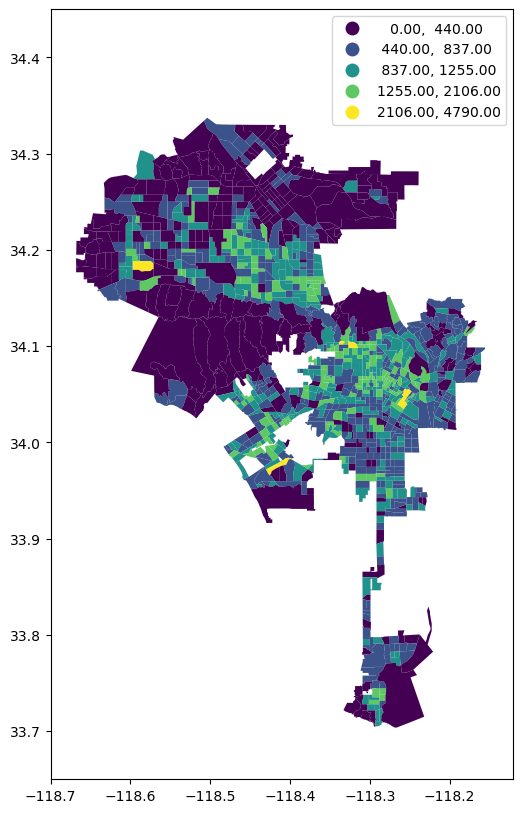

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
RentBurdenLACity.plot(
                 column='Renter-Occupied Housing Units',
                 legend=True, 
                 scheme='NaturalBreaks',
                 ax=ax)

ax.set_ylim(33.65, 34.45)
ax.set_xlim(-118.7,-118.12)

### The Geographic Distribution of LIHTC Units

In order to start data exploration, I will need to use the pandas library and load the data I downloaded from the USC Neighborhood Data for Social Change

In [48]:
import pandas as pd

In [49]:
LIHTC = pd.read_csv('data/All Years LIHTC Calculations with FIPS.csv')

In [50]:
LIHTC = pd.read_csv(
    'data/All Years LIHTC Calculations with FIPS.csv',
    dtype=
    {
        'FIPS':str,
    }
)

In [51]:
columns_to_keep = ['FIPS',
                   'li_units_count']
LIHTCunits = LIHTC[columns_to_keep]

In [52]:
LIHTCunits

,FIPS,li_units_count
0,06037101400,45
1,06037103102,81
2,06037104105,475
3,06037104108,48
4,06037104703,62
...,...,...
4981,06037920102,149
4982,06037920112,264
4983,06037920312,66
4984,06037980010,27


I have successfully defined the two columns I want to keep in the new variable LITHCunits. I will start examining this data with commands to produce some introductory/simple statistics, such as the .describe() command.

In [53]:
LIHTCunits['li_units_count'].describe()

count    4986.000000
mean      119.051344
std       121.635817
min         2.000000
25%        42.000000
50%        80.000000
75%       154.000000
max      1142.000000
Name: li_units_count, dtype: float64

Here I see the average number of low-income housing units in LIHTC developments in the census tracts that do have them. I also see that the minimum amount of units is 2 while the maximum is 1,142 units in one particular census tract - which is a very large range. I will now plot the low income units variable as a histogram with 30 bins

<AxesSubplot: ylabel='Frequency'>

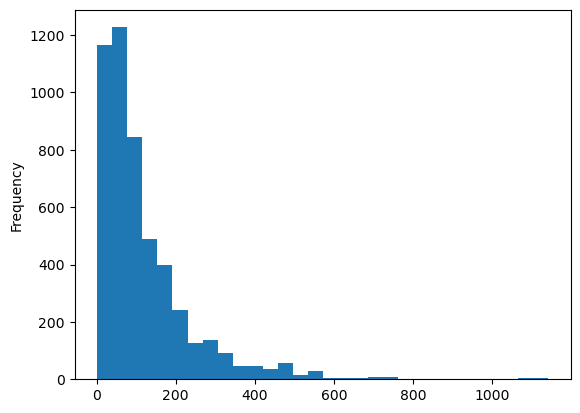

In [54]:
LIHTCunits['li_units_count'].plot.hist(bins=30)

This histogram shows that the large majority of census tracts that do have LIHTC units with low income units typically have low amounts of these units while there are some notable outliers on the higher end - I can also generate a box plot for the same varible below, and see the outliers as well

<AxesSubplot: >

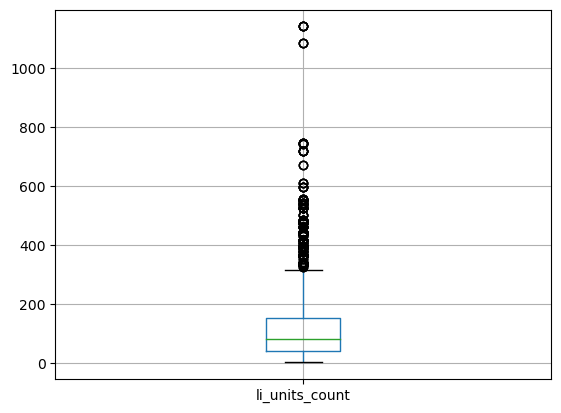

In [55]:
LIHTCunits.boxplot(column=['li_units_count'])

I am curious to see the top 10 census tracts that have the most amount of low income housing units. I can sort the data by this column using the sort_values function

In [56]:
LIHTCunits_sorted = LIHTCunits.sort_values(by='li_units_count',ascending = False)

In [57]:
LIHTCneighborhoods=LACountyTracts.merge(LIHTCunits,on="FIPS")

In [58]:
LIHTCLACity_web_mercator = LIHTCLACity.to_crs(epsg=3857)

NameError: name 'LIHTCLACity' is not defined

In [ ]:
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))

#adding colour to the plot
LIHTCLACity_web_mercator.plot(
            ax=ax,   
            column = 'li_units_count',   # column that defines the color of the dots
            scheme='NaturalBreaks',
            legend = True     # add a legend           
)
                
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('LIHTC Low-Income Units in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, crs=3857)

### Socioeconomic Disparities in Los Angeles

To look at socioeconomic disparities, I have used the data on poverty rates in LA County census tracts as only looking at average and median income would not highlight income/wealth disparities that may exist. For this data, I am using percentage of the population living in a family earning below 100% or 200% of the federal poverty threshold in LA county census tracts (which I will later refine for the city of Los Angeles).

In [ ]:
import pandas as pd

In [ ]:
Poverty = pd.read_csv('data/2021 Poverty Calculations LA County.csv')

In [ ]:
Poverty = pd.read_csv(
    'data/2021 Poverty Calculations LA County.csv',
    dtype=
    {
        'FIPS':str,
    }
)

In [ ]:
columns_to_keep = ['FIPS',
                   'pop_below_100_pct',
                   'pop_below_200_pct',
                  ]

In [ ]:
PovertyPercent = Poverty[columns_to_keep]

In [ ]:
PovertyLACity=RentBurdenLACity.merge(PovertyPercent,on="FIPS")

In [ ]:
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))

#adding colour to the plot
PovertyLACity_web_mercator.plot(
            ax=ax,   
            column='pop_below_200_pct',
            legend=True, 
            scheme='NaturalBreaks'          
)
                
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Below 200% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

In [ ]:
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))

#adding colour to the plot
PovertyLACity_web_mercator.plot(
            ax=ax,   
            column='pop_below_100_pct',
            legend=True, 
            scheme='NaturalBreaks'          
)
                
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Below 100% Poverty Threshold')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

In [ ]:
RentBurdenLACity_web_mercator = RentBurdenLACity.to_crs(epsg=3857)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
RentBurdenLACity_web_mercator.plot(
                 column='Residents Paying 50% or more of Income on Rent',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Number of Residents Paying 50% or more of Income on Rent')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
RentBurdenLACity_web_mercator.plot(
                 column='Residents Paying 30% to 49% of Income on Rent',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Number of Residents Paying 30% to 49% of Income on Rent')

# add a basemap
ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

# Mapping Housing Tenure
Status as a renter or homeowner is hugely important context for our analysis. As renters people have far less options and leverage when faced with rising rents and gentrification. Conversely, high income homeowners enjoy a great deal of economic stability and are much less vulnerable to the impacts of new development in their neighborhoods. 

In [ ]:
# step 1- import your data (needs to have a geometry column) 
tenure=pd.read_csv('data/tenuretracts.csv')

In [ ]:
# Step 2- plug it into the function 
tenure= nhdissolve(df=tenure,geometry='geometry')

In [ ]:
# Don't worry about the warning^^ it's just talking about one of the functions that's due for a change
# Step 3- Do whatever you want with your newly adjusted geodataframe 
tenure.head()

In [ ]:
# adding new rows with percent of renters and owners based on total number of households
tenure['Percent Renter Occupied'] = tenure['Occupied Housing Units: Renter Occupied'] / tenure['Occupied Housing Units'] * 100
tenure['Percent Owner Occupied'] = tenure['Occupied Housing Units: Owner Occupied'] / tenure['Occupied Housing Units'] * 100
tenure.head(10)

In [ ]:
tenure_web_mercator = tenure.to_crs(epsg=3857)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
tenure_web_mercator.plot(
                 column='Percent Renter Occupied',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.axis('off')

ax.set_title('Percent of Renter Occupied Households')

ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

## Results
This map shows which neighborhoods have the highest percentage of renter occupied households, most of which are located in central and south LA and North Hollywood. This map builds upon the census tract level rentership map in our midterm. By mapping housing tenure data at the neighborhood level, we can gain a broader understanding of the communities where wealth is concentrated and which communities are more economically vulnerable.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
tenure_web_mercator.plot(
                 column='Percent Owner Occupied',
                 legend=True, 
                 scheme='quantiles',
                 ax=ax)

ax.axis('off')

ax.set_title('Percent of Owner Occupied Households')

ctx.add_basemap(ax, crs=3857, source=ctx.providers.Stamen.TonerLite)

# Results
An inverse to the first map, this map shows the neighborhoods with the highest percentage of owner occupied households, which are predominately located around the rim of the San Fernando Valley. Further analysis of the percent of neighborhood area zoned for single family/multifamily dwellings will provide insight into the impact of land use regulations on housing tenure, housing stability, and equity gained through homeownership. 

In [ ]:
tenure_sorted = tenure.sort_values(by='Percent Renter Occupied',ascending = False)

In [ ]:
fig = px.bar(tenure_sorted.head(10),
       y='Percent Renter Occupied',
       title='Top 10 Neighborhoods with the Highest Percent of Renter Occupied Households'
      )
fig.update_traces(marker_line_width=0)

fig.show()

## Results
This chart shows the 10 neighborhoods in the city of LA with the highest rates of renter occupied households. Six of the ten neighborhoods have rentership rates of 90% or greater. Based on our analysis of race in the midterm, we know that these neighborhoods are predominately neighborhoods of color and also face high rates of rent burden. 

In [ ]:
fig = px.bar(tenure_sorted.tail(10),
       y='Percent Owner Occupied',
       title='Top 10 Neighborhoods with the Highest Percent of Owner Occupied Households'
      )
fig.update_traces(marker_line_width=0)

fig.show()

## Results
This chart shows the 10 neighborhoods in the city of LA with the highest rates of renter occupied households. Affluent, predominately white neighborhoods such as Beverly Crest, Bel-Air, and Pacific Palisades were unsuprisingly included in this list. However, predominately Latinx communities such as Arleta, Lake View Terrace, and Mission Hills also have high rates of homeownership, which demonstrates the role of other variables beyond race in determining a household's tenure status. 

# High Opportunity Neighborhoods and Affordable Housing

Resources (e.g. access to parks, quality schools, grocery stores) in the City of Los Angeles are particualrly segregated. We will see this in the State of California TCAC Opportunity Maps below. In order to demonstrate the role that segregated housing development plays in upholding this dynamic we will overlay points of market rate and affordable housing development over our neighborhood opportunity maps. 


In [ ]:
# import data to run neighborhood function
opmap=pd.read_csv('data/opportunity.csv')
#add numeric values based on opportunity category 
opmap['Opportunity Number'] = opmap['oppcat']
opmap['Opportunity Number'] =opmap['Opportunity Number'].replace(['Highest Resource', 'High Resource','Moderate Resource','Low Resource','High Segregation & Poverty'], [1,2,3,4,5])


In [ ]:
# run the dissolve function
opmapgdf= nhdissolve(df=opmap,geometry='geometry',math='mean',skip=False)
# re-associate the integer with the category
opmapgdf['Opportunity Number']=opmapgdf['Opportunity Number'].round()
opmapgdf['oppcat']=opmapgdf['Opportunity Number']
opmapgdf['oppcat'] =opmapgdf['oppcat'].replace([1,2,3,4,5],['Highest Resource', 'High Resource','Moderate Resource','Low Resource','High Segregation & Poverty'])
# re-add color column

In [ ]:
from pathlib import Path  

filepath = Path('oppmapgdf.csv')

filepath.parent.mkdir(parents=True, exist_ok=True)  

df.to_csv(filepath)  

In [ ]:
#plotting with assigned colours
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))

#adding colour to the plot
opmapgdf.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            cmap = 'gist_rainbow', 
            legend = True,     # add a legend        
            
            edgecolor = 'grey',
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )
          
# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('High opportunity areas in the City of Los Angeles')

# add a basemap
ctx.add_basemap(ax, crs=4326)

## Results
We can see a pattern emerging between predominantly White neighborhoods and higher resources. on the Westside and in the West Valley we have the highest concentration of high opportunity neighborhoods. 

# Mapping Affordable Housing On Top Of Opporunity 
Now we can add a map of afforable housing produced from 2016

In [ ]:
# Import housing points and assign CRS
ah=pd.read_csv('data/ahunits.csv')
ah['geometry'] = ah['geometry'].apply(wkt.loads)
ahgdf = gpd.GeoDataFrame(ah, crs="EPSG:4326",geometry='geometry')

#filtering only affordable housing projects
newunits_AH = ahgdf.loc[ahgdf['AFFD'] == 'AH']

In [ ]:
#starting the plot
fig, ax = plt.subplots(figsize=(20,12))



#adding colour to the plot
opmapgdf.plot(
            ax=ax,   
            column = 'oppcat',   # column that defines the color of the dots
            cmap = 'tab10', 
            legend = True,     # add a legend        
            
            edgecolor = 'black',
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
            }
        
            )

newunits_AH.plot(
                   ax=ax,   
            markersize = 2, 
            color = 'red',
            legend = True,     # add a legend 
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1,1),
                'labels':'Housing units',
            }                  # this puts the legend to the side
) 

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('Analysis of Affordable Housing production with respect to High Opportunity Areas in Los Angeles')

# add a basemap at 40% transparency
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Stamen.Terrain, alpha=0.5)



## Results: 
We can see that the bulk of the afforable housing (in red) is concentrated in lower opportunity areas. A lack of affordable housing in high opportunity areas reinforces segregation and prevents people who work in or would like to live in high opportunity neighborhoods from doing so. 

# Charting the Numnber of Affordable Units LA Neighborhoods
A bar chart will help us better understand in which neighborhoods affordable developments are concentrated.

In [ ]:
#Spatial join 
TCAC_nb = gpd.sjoin(opmapgdf, newunits_AH) 


In [ ]:
#creating a dataset using th value counts based on number of affordable housing units built after 2015, per neighborhoods
nb_AH_sorted = TCAC_nb.value_counts(['Neighborhood','AFFD']).reset_index(name='count')


In [ ]:
# make a stacked bar chart of the number of affordable housing projects built per neighborhood
import plotly.express as px
fig = px.bar(nb_AH_sorted.head(15),
       x='Neighborhood',
       y='count',
      
        labels={
            'Neighborhood':'Neighborhoods in the City of Los Angeles (15 Highest for AH)',
            'count':'No. of AH units built after 2015'
        }
)

fig.show()

## Results
As we saw in the map, the highest concentration of affordable housing is in lower income, majority POC Neighborhoods. The two largest being Westlake and East Hollywood. While affordable housing is deeply needed everywhere, the delta between these neighborhoods and higher opportunity neighborhoods helps to reinforce economic and racial segregation. 

# Creating a Housing to Jobs Ratio Map

Jobs are the [number one reason](https://www.theladders.com/career-advice/jobs-are-the-top-reason-people-move-and-this-city-is-where-most-of-them-are-heading) that young adults move in the US. In Los Angeles there are many job centers beyond just DTLA. This section will create a ratio of jobs to housing for different neighborhoods to show where housing is undersupplied. The hypothesis here is that an undersupply of housing in high-jobs, high-opportunity areas is both upholding segregation and accelerating gentrification in lower income neighborhoods.

In [ ]:
# Import housing and jobs by neighborhood data 
jh=pd.read_csv('data/jh.csv')
# adding a CRS
jh['geometry'] = jh['geometry'].apply(wkt.loads)
jhgdf = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')
jhgdf.head()

In [ ]:
# Create a map of Jobs housing Ratio with housing and jobs layers
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

#Quantile layer
folium.Choropleth(
    geo_data=jh,
    name="Number of Jobs Per Unit of Housing",
    data=jh,
    columns=["Neighborhood","Jobs to Housing Quantiles"],
    key_on="feature.properties.Neighborhood",
    fill_color="BuPu",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="Jobs to Housing Quantiles",
).add_to(m)
    
#Jobs layer
folium.Choropleth(
    geo_data=jh,
    name="Jobs Per Neighborhood",
    data=jh,
    columns=["Neighborhood","Number of Jobs"],
    key_on="feature.properties.Neighborhood",
    fill_color="PuBuGn",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="Jobs Per Neighborhood",
    show=False,

).add_to(m)
    
#Housing layer
folium.Choropleth(
    geo_data=jh,
    name="Housing Units Per Neighborhood",
    data=jh,
    columns=["Neighborhood","Units of Housing"],
    key_on="feature.properties.Neighborhood",
    fill_color="OrRd",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="Housing Units Per Neighborhood",
    show=False,

).add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
# Save the map
m.save("MidtermJobsHousingMap.html")

## Results 

We can see that both Westside and more affluent neighborhoods have a lot more jobs than housing compared to the rest of the city. Further below I will make a stacked bar chart to show how racial demographics are correlated with this dynamic. 

# Creating a Dynamic Bar Chart of the Worst Offenders

To better understand the racial makeup of neighborhoods with a great deal of jobs and very little housing, we will create a stacked bar chart.

In [ ]:
# Import merged race and housing stats 
mergedstats=pd.read_csv('data/mergedstats.csv')
# Sort data 
sorted2=mergedstats.sort_values(by='Number of Jobs Per Unit of Housing', ascending=False,)
# List relevant columns 
raceper2=['Percent Non Hispanic White Alone',
 'Percent Non Hispanic Black Alone',
 'Percent Non Hispanic American Indian and Alaska Native Alone',
 'Percent Non Hispanic Asian Alone',
 'Percent Non Hispanic Native Hawaiian and Pacific Islander Alone',
 'Percent Non Hispanic Other Alone',
 'Percent Non Hispanic Multi Race',
 'Percent Hispanic']
# Create stacked bar chart 
fig = px.bar(sorted2.head(10),
    x='Neighborhood',
            y=raceper2,
            labels={'Demographic Percentages'})
# Adding titles
fig.update_layout(
    title='Demographic Breakdown of High Job, Low Housing Neighborhoods',
    yaxis=dict(
        title='Population Percent'))

fig.show()

## Results 

This bar chart shows us that all of the highest housing/jobs imbalance neighborhoods are predominantly White. The worst offender, Century City is almost 80% White, even though White people are a statistical minority in LA County. Further work can explore the geostatistical significance of these differences, as well as examine how this data has changed over time. This dataset is from 2019, but there is available data dating about a decade. 

In [ ]:
# Import housing and jobs by neighborhood data 
jh=pd.read_csv('data/jh.csv')
# adding a CRS
jh['geometry'] = jh['geometry'].apply(wkt.loads)
jhgdf = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')